# Data Cleaning 


In [2]:
import pandas as pd
import numpy as np 
import os 
from pyspark.sql import SparkSession
from dotenv import load_dotenv
from datetime  import datetime

In [3]:
os.chdir('..')

In [4]:
from src.data_ingestion.data_ingestion import load_csv_to_hadoop , read_csv_data_from_hadoop
from src.utils.data_preprocessing import is_missing_value, remove_outliers , find_outlier_box_plot , find_outliers_IQR , drop_outlier_columns

In [5]:
load_dotenv()
hadoop_raw_data_path = os.getenv('hadoop_raw_data_path')
customer_data_path ='/customer.csv'
path = hadoop_raw_data_path + customer_data_path

In [6]:
# initialize spark session

data = read_csv_data_from_hadoop(hadoop_data_directory= path)

In [7]:

data.show()

+-----------+----------+-----------+--------------------+--------------------+------+----------+-----------+--------------------+--------------------+-------------------+------------------+-------------------+------------+---------------+
|customer_id|first_name|  last_name|            username|               email|gender| birthdate|device_type|           device_id|      device_version|  home_location_lat|home_location_long|      home_location|home_country|first_join_date|
+-----------+----------+-----------+--------------------+--------------------+------+----------+-----------+--------------------+--------------------+-------------------+------------------+-------------------+------------+---------------+
|       2870|      Lala|    Maryati|671a0865-ac4e-4dc...|671a0865_ac4e_4dc...|     F|1996-06-14|        iOS|c9c0de76-0a6c-4ac...|iPhone; CPU iPhon...|-1.0433453720910766| 101.3605227696372|     Sumatera Barat|   Indonesia|     2019-07-21|
|       8193|  Maimunah| Laksmiwati|83be2ba7

In [8]:
df = pd.DataFrame(data.take(data.count()), columns=data.columns)
df.head()

,customer_id,first_name,last_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date
0,2870,Lala,Maryati,671a0865-ac4e-4dc4-9c4f-c286a1176f7e,671a0865_ac4e_4dc4_9c4f_c286a1176f7e@startupca...,F,1996-06-14,iOS,c9c0de76-0a6c-4ac2-843f-65264ab9fe63,iPhone; CPU iPhone OS 14_2_1 like Mac OS X,-1.043345,101.360523,Sumatera Barat,Indonesia,2019-07-21
1,8193,Maimunah,Laksmiwati,83be2ba7-8133-48a4-bbcb-b46a2762473f,83be2ba7_8133_48a4_bbcb_b46a2762473f@zakyfound...,F,1993-08-16,Android,fb331c3d-f42e-40fe-afe2-b4b73a8a6e25,Android 2.2.1,-6.212489,106.818850,Jakarta Raya,Indonesia,2017-07-16
2,7279,Bakiman,Simanjuntak,3250e5a3-1d23-4675-a647-3281879d42be,3250e5a3_1d23_4675_a647_3281879d42be@startupca...,M,1989-01-23,iOS,d13dde0a-6ae1-43c3-83a7-11bbb922730b,iPad; CPU iPad OS 4_2_1 like Mac OS X,-8.631607,116.428436,Nusa Tenggara Barat,Indonesia,2020-08-23
3,88813,Cahyadi,Maheswara,df797edf-b465-4a80-973b-9fbb612260c2,df797edf_b465_4a80_973b_9fbb612260c2@zakyfound...,M,1991-01-05,iOS,f4c18515-c5be-419f-8142-f037be47c9cd,iPad; CPU iPad OS 14_2 like Mac OS X,1.299332,115.774934,Kalimantan Timur,Indonesia,2021-10-03
4,82542,Irnanto,Wijaya,36ab08e1-03de-42a8-9e3b-59528c798824,36ab08e1_03de_42a8_9e3b_59528c798824@startupca...,M,2000-07-15,iOS,e46e4c36-4630-4736-8fcf-663db29ca3b0,iPhone; CPU iPhone OS 10_3_3 like Mac OS X,-2.980807,114.924675,Kalimantan Selatan,Indonesia,2021-04-11


In [9]:
df.shape

(100000, 15)

In [10]:
is_missing_value(df)

np.False_

In [11]:
df.dtypes

customer_id             int64
first_name             object
last_name              object
username               object
email                  object
gender                 object
birthdate              object
device_type            object
device_id              object
device_version         object
home_location_lat     float64
home_location_long    float64
home_location          object
home_country           object
first_join_date        object
dtype: object

In [12]:
# check if the column gender has values other than female or male (F or M)

allowed_values = {"F", 'f', 'M', 'm'}
invalid_rows = df[~df['gender'].isin(allowed_values)]

if not invalid_rows.empty:
    print("Found rows with invalid gender values:")
    print(invalid_rows)
else:
    print("All rows have valid gender values (F or M).")


All rows have valid gender values (F or M).


In [13]:
# data type conversion
df['birthdate'] = pd.to_datetime(df['birthdate'], errors='coerce')
df['first_join_date'] = pd.to_datetime(df['first_join_date'], errors='coerce')

# converting the following columns to category data type to save memory

df['gender'] = df['gender'].astype('category')
df['device_type'] = df['device_type'].astype('category')
df['home_country'] = df['home_country'].astype('category')

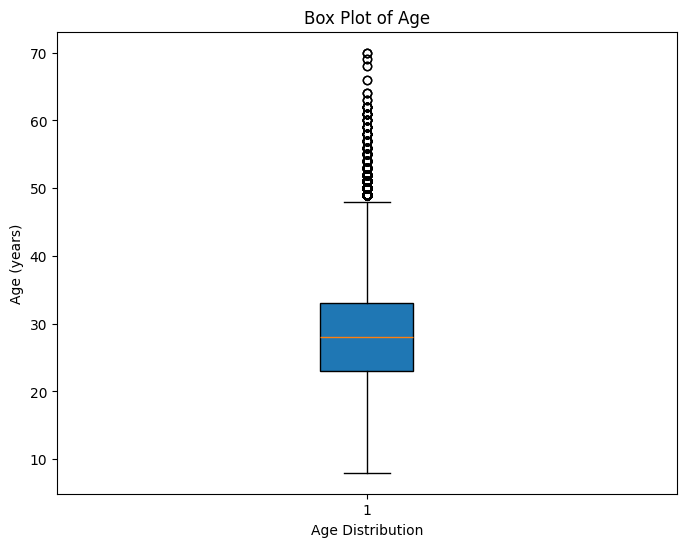

In [14]:
# check for outliers in the age column derived from the birthdate column
today = pd.Timestamp.today()
df['age'] = ((today - df['birthdate']).dt.days / 365).astype(int)
find_outlier_box_plot(df=df, column='age')

In [15]:
age_outliers = find_outliers_IQR(df=df, column='age')
age_outliers

,customer_id,first_name,last_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date,age
108,28128,Samsul,Dabukke,005b3146-62ee-45c2-9474-affac76493ec,005b3146_62ee_45c2_9474_affac76493ec@zakyfound...,M,1975-10-07,iOS,2647c2b7-c6da-4cb5-bcea-9591ad9c565a,iPhone; CPU iPhone OS 12_4_8 like Mac OS X,-8.088126,110.505761,Yogyakarta,Indonesia,2022-03-06,49
119,10225,Eli,Wijayanti,66da899f-4033-42e3-8f18-b415bbeb61d0,66da899f_4033_42e3_8f18_b415bbeb61d0@startupca...,F,1974-05-20,Android,41981909-f3c1-4dd7-9b21-1eb7c554d9e8,Android 2.3.6,-1.562462,110.393105,Kalimantan Barat,Indonesia,2021-01-17,50
207,57901,Devi,Hastuti,cc3ebab7-0f94-4b95-a4fd-fbf9c7201bd5,cc3ebab7_0f94_4b95_a4fd_fbf9c7201bd5@zakyfound...,F,1973-09-27,Android,0d19b7e5-6ba0-4a2d-9b53-a6552bfe3820,Android 4.2.2,-8.362891,116.295390,Nusa Tenggara Barat,Indonesia,2017-07-08,51
442,70246,Anita,Mardhiyah,e59bcbe2-b5c2-4300-9e5b-247f86d704de,e59bcbe2_b5c2_4300_9e5b_247f86d704de@startupca...,F,1975-10-12,Android,6ebdcbb9-c8f6-48c0-9253-08d899886059,Android 2.3.7,-6.361084,106.895619,Jakarta Raya,Indonesia,2022-01-01,49
505,79632,Kambali,Saragih,21cd19c3-d94b-4d41-8880-f3e78111e10f,21cd19c3_d94b_4d41_8880_f3e78111e10f@startupca...,M,1973-01-18,Android,e443f348-bec6-480d-b861-f14d8a7aa14a,Android 5.0,-8.009821,114.223421,Jawa Timur,Indonesia,2022-03-26,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99705,95224,Ikhsan,Maryadi,c5bc056d-ee7e-4478-abf4-ba4c9ec3d312,c5bc056d_ee7e_4478_abf4_ba4c9ec3d312@startupca...,M,1974-12-15,Android,512b578f-2bc3-4b0a-a741-7524cb1c108c,Android 7.1.2,-7.786895,110.387239,Yogyakarta,Indonesia,2022-01-09,50
99734,52864,Elisa,Laksita,1690bcb3-bd26-4983-a4da-f160f1d92434,1690bcb3_bd26_4983_a4da_f160f1d92434@zakyfound...,F,1975-07-24,Android,b7316783-6142-4f12-98e6-dbb93932eb9d,Android 10,-3.557473,130.307380,Maluku,Indonesia,2022-05-14,49
99813,33278,Ilsa,Yuliarti,d7ea2bdb-f396-4317-98dc-7243b46ba2ec,d7ea2bdb_f396_4317_98dc_7243b46ba2ec@startupca...,F,1974-02-01,Android,201fe4f1-c28f-44df-917a-1f342c7d06d6,Android 4.4.4,-3.637717,102.431031,Bengkulu,Indonesia,2020-03-28,51
99844,24550,Kamila,Maryati,a67c2f6c-661b-4ec0-953e-8dd319984e67,a67c2f6c_661b_4ec0_953e_8dd319984e67@zakyfound...,F,1974-09-20,Android,7b1a0c5d-859e-4acd-a2d7-e41eada2c4a3,Android 4.2,-7.271890,110.047244,Jawa Tengah,Indonesia,2018-06-03,50


In [ ]:
clean_df = drop_outlier_columns(df=df, outlier_columns= pd.DataFrame(age_outliers), column_name_to_drop='age')


# #check again with box plot
# find_outlier_box_plot(df=clean_df, column='age')
clean_df

""
0
1
2
3
4
...
99995
99996
99997
99998
